In [2]:
import pandas as pd
import numpy as np
import os
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy
from IPython.display import display, HTML
from typing import List, Callable, Dict
from nltk.corpus import stopwords
import re
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD

In [3]:
pd.set_option('display.max_rows',10)

#### Import Data

In [4]:
data = pd.read_csv('/Users/dylanhayashi/Desktop/Northwestern/MSDS_453_Public/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv')

#### Data Wrangling

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [6]:
def nlp_transformations(df):
    """
    Apply NLP transformations to a pandas DataFrame.
    Parameters: df (DataFrame): Input dataframe with a column named 'Text'.
    Returns: DataFrame: A new dataframe with added columns for each NLP transformation.
    """
    df['Tokens'] = df['Text'].apply(word_tokenize)
    df['Normalized'] = df['Tokens'].apply(lambda x: [word.lower() for word in x])
    df['Lemmatized'] = df['Normalized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    df['No_Stop_Words'] = df['Lemmatized'].apply(lambda x: [word for word in x if word not in stop_words])
    df['Cleaned'] = df['No_Stop_Words'].apply(lambda x: [re.sub(r'[^a-zA-Z]', '', word) for word in x])
    df['Cleaned'] = df['Cleaned'].apply(lambda x: [word for word in x if word != ''])
    df['wrangle_one'] = df['Normalized']
    df['wrangle_two'] = df['No_Stop_Words']
    df['wrangle_three'] = df['Cleaned']
    return df

In [7]:
wrangled_data = nlp_transformations(data).sort_values('Genre of Movie')
wrangled_data

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Tokens,Normalized,Lemmatized,No_Stop_Words,Cleaned,wrangle_one,wrangle_two,wrangle_three
0,160,ARE_Doc1_Taxi,Jimmy Fallon's big screen career may be over b...,ARE_Doc1_Taxi,ARE,Action,Negative,Taxi,"[Jimmy, Fallon, 's, big, screen, career, may, ...","[jimmy, fallon, 's, big, screen, career, may, ...","[jimmy, fallon, 's, big, screen, career, may, ...","[jimmy, fallon, 's, big, screen, career, may, ...","[jimmy, fallon, s, big, screen, career, may, e...","[jimmy, fallon, 's, big, screen, career, may, ...","[jimmy, fallon, 's, big, screen, career, may, ...","[jimmy, fallon, s, big, screen, career, may, e..."
116,46,KCM_Doc7_AngelHasFallen,Authorities take Secret Service agent Mike Ban...,KCM_Doc7_AngelHasFallen,KCM,Action,Positive,Angel Has Fallen,"[Authorities, take, Secret, Service, agent, Mi...","[authorities, take, secret, service, agent, mi...","[authority, take, secret, service, agent, mike...","[authority, take, secret, service, agent, mike...","[authority, take, secret, service, agent, mike...","[authorities, take, secret, service, agent, mi...","[authority, take, secret, service, agent, mike...","[authority, take, secret, service, agent, mike..."
115,45,KCM_Doc6_AngelHasFallen,American movie presidents can only make us wis...,KCM_Doc6_AngelHasFallen,KCM,Action,Positive,Angel Has Fallen,"[American, movie, presidents, can, only, make,...","[american, movie, presidents, can, only, make,...","[american, movie, president, can, only, make, ...","[american, movie, president, make, u, wistful,...","[american, movie, president, make, u, wistful,...","[american, movie, presidents, can, only, make,...","[american, movie, president, make, u, wistful,...","[american, movie, president, make, u, wistful,..."
114,44,KCM_Doc5_AngelHasFallen,"No, you dont need to have seen Olympus Has F...",KCM_Doc5_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,"[No, ,, you, dont, need, to, have, seen, Oly...","[no, ,, you, dont, need, to, have, seen, oly...","[no, ,, you, dont, need, to, have, seen, oly...","[,, dont, need, seen, olympus, ha, fallen, ...","[dont, need, seen, olympus, ha, fallen, andor,...","[no, ,, you, dont, need, to, have, seen, oly...","[,, dont, need, seen, olympus, ha, fallen, ...","[dont, need, seen, olympus, ha, fallen, andor,..."
113,43,KCM_Doc4_AngelHasFallen,There is a certain mindless pleasure in the Fa...,KCM_Doc4_AngelHasFallen,KCM,Action,Negative,Angel Has Fallen,"[There, is, a, certain, mindless, pleasure, in...","[there, is, a, certain, mindless, pleasure, in...","[there, is, a, certain, mindless, pleasure, in...","[certain, mindless, pleasure, fallen, movie, ....","[certain, mindless, pleasure, fallen, movie, w...","[there, is, a, certain, mindless, pleasure, in...","[certain, mindless, pleasure, fallen, movie, ....","[certain, mindless, pleasure, fallen, movie, w..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,54,JTG_Doc5_Oblivion,What do you need for the ultimate Tom Cruise v...,JTG_Doc5_Oblivion,JTG,Sci-Fi,Negative,Oblivion,"[What, do, you, need, for, the, ultimate, Tom,...","[what, do, you, need, for, the, ultimate, tom,...","[what, do, you, need, for, the, ultimate, tom,...","[need, ultimate, tom, cruise, vehicle, ?, vehi...","[need, ultimate, tom, cruise, vehicle, vehicle...","[what, do, you, need, for, the, ultimate, tom,...","[need, ultimate, tom, cruise, vehicle, ?, vehi...","[need, ultimate, tom, cruise, vehicle, vehicle..."
133,53,JTG_Doc4_Oblivion,"In Oblivion, Tom Cruise plays a post-apocaly...",JTG_Doc4_Oblivion,JTG,Sci-Fi,Negative,Oblivion,"[In, Oblivion, ,, , Tom, Cruise, plays, a, p...","[in, oblivion, ,, , tom, cruise, plays, a, p...","[in, oblivion, ,, , tom, cruise, play, a, po...","[oblivion, ,, , tom, cruise, play, post-apoc...","[oblivion, tom, cruise, play, postapocalyptic,...","[in, oblivion, ,, , tom, cruise, plays, a, p...","

#### Create visualization legend dictionaries

In [8]:
unique_titles = wrangled_data['Movie Title'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_titles)))
color_map = dict(zip(unique_titles, colors))

unique_genres = wrangled_data['Genre of Movie'].unique()
markers = ['o', 's', '^', 'D']  # Example: circle, square, triangle, diamond
if len(markers) < len(unique_genres):
    raise ValueError("Please provide at least as many marker shapes as there are unique genres.")
marker_map = dict(zip(unique_genres, markers))

#### Part 1: Clustering via tf-idf or Doc2Vec

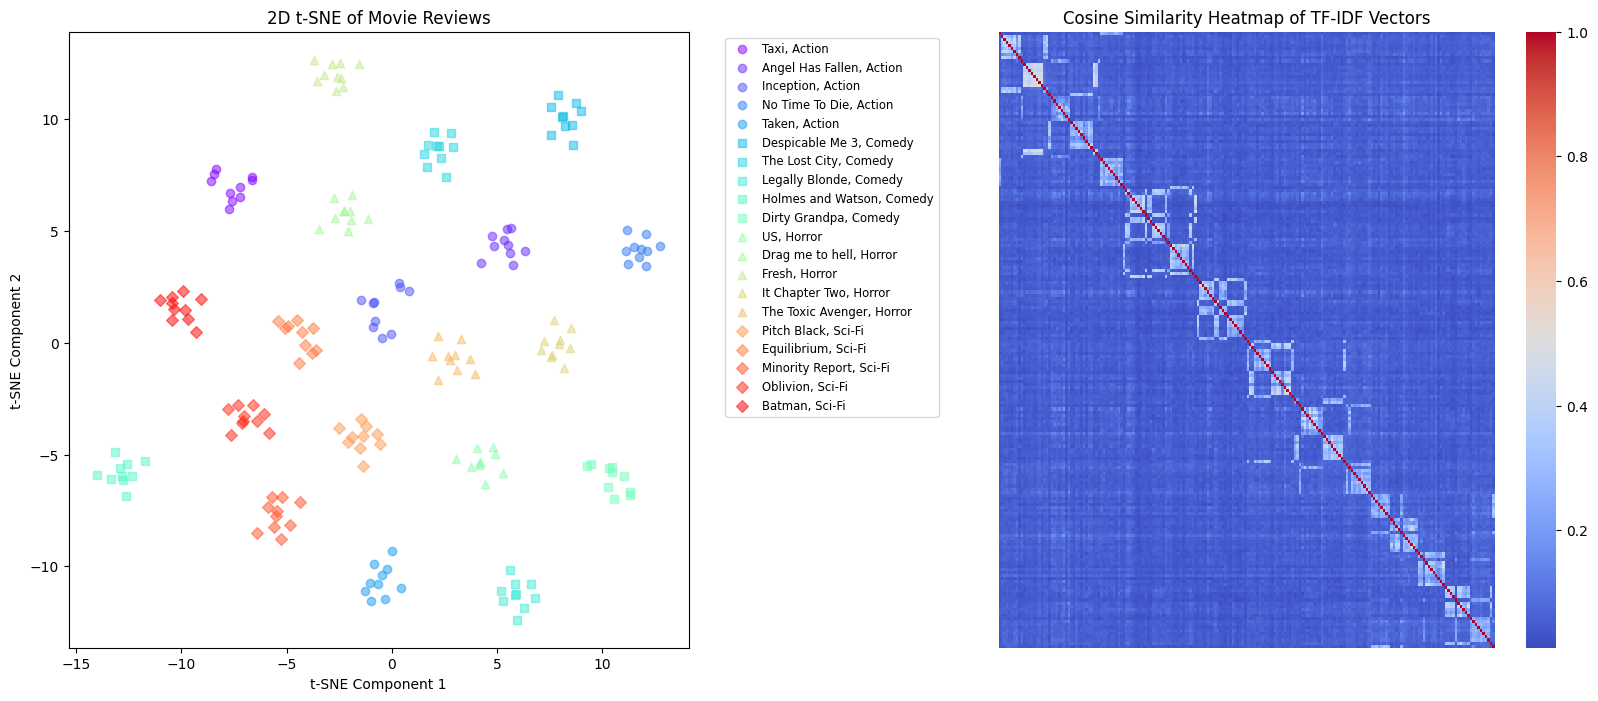

In [9]:

# Assume `wrangled_data`, `unique_titles`, and `unique_genres` are predefined
# Assume `color_map` and `marker_map` are predefined

# Vectorization
vectorizer = TfidfVectorizer()  # Consider limiting features
X_tfidf = vectorizer.fit_transform(wrangled_data['wrangle_three'].apply(' '.join))

# Model Fitting
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11, n_jobs=-1)
model_knn.fit(X_tfidf)

# Finding Neighbors (excluding the point itself)
distances, indices = model_knn.kneighbors(X_tfidf, n_neighbors=11)

# Dimensionality Reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_tfidf)

# Cosine Similarity
cosine_sim = cosine_similarity(X_tfidf)

# Creating Subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns
plt.subplots_adjust(wspace=0.5) # you can adjust this value to manage the space

# t-SNE Visualization
ax = axs[0]

for title in unique_titles:
    for genre in unique_genres:
        mask = (wrangled_data['Movie Title'] == title) & (wrangled_data['Genre of Movie'] == genre)
        if mask.sum() == 0:
            continue
        
        ax.scatter(
            X_embedded[mask, 0], X_embedded[mask, 1],
            color=color_map[title], marker=marker_map[genre],
            alpha=0.5, label=f"{title}, {genre}"
        )

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('2D t-SNE of Movie Reviews')

# Cosine Similarity Heatmap
ax = axs[1]

sns.heatmap(cosine_sim, ax=ax, cmap='coolwarm', xticklabels=False, yticklabels=False)
ax.set_title('Cosine Similarity Heatmap of TF-IDF Vectors')
plt.show()


#### Part 2: Clustering via LSA

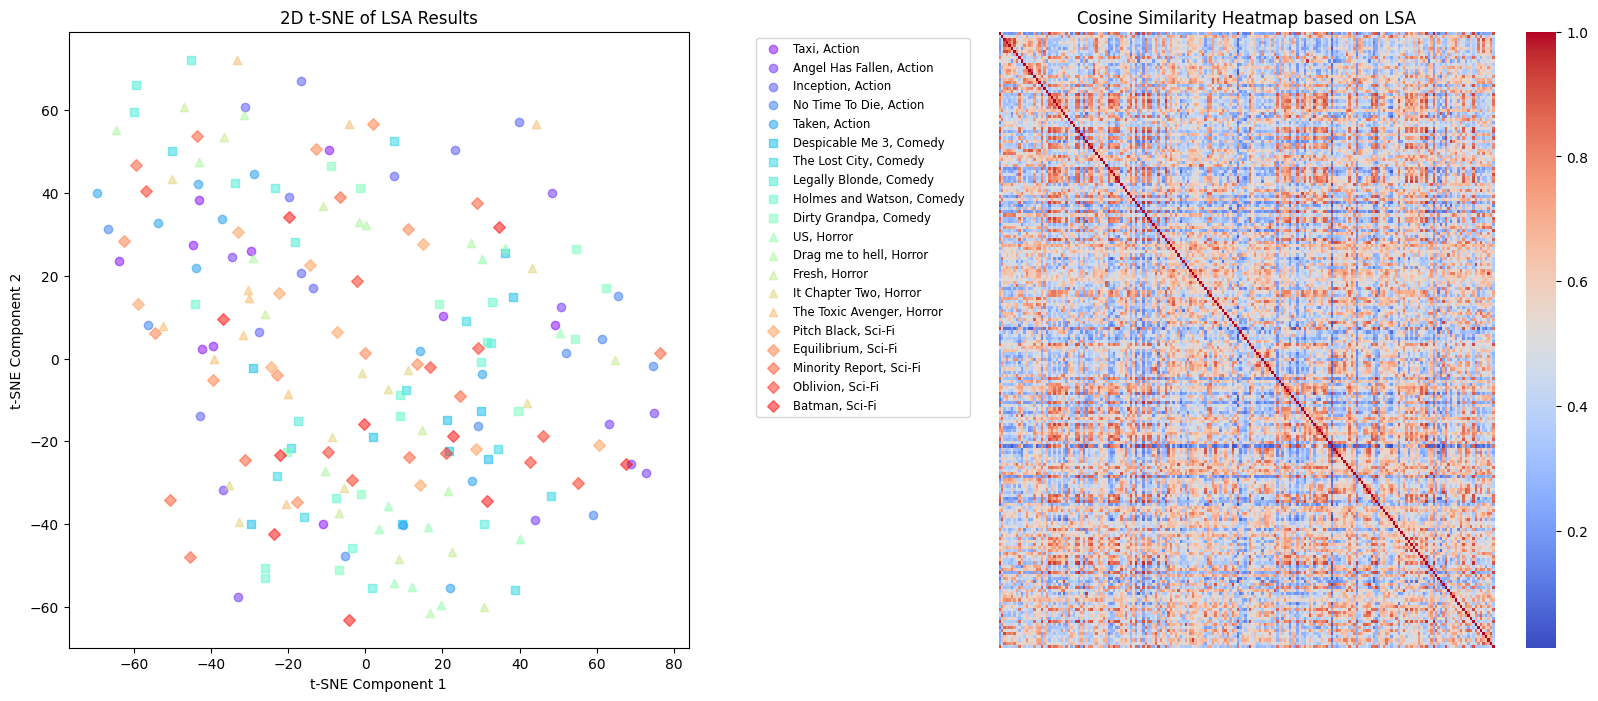

In [24]:


# Assuming wrangled_data, unique_titles, and unique_genres are defined
# Define color_map and marker_map here

# Convert tokenized words into a document-term matrix
def dummy(doc):
    return doc

vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
X_count = vectorizer.fit_transform(wrangled_data['wrangle_three'])

# Fit LSA model using TruncatedSVD
lsa = TruncatedSVD(n_components=20, random_state=42)  # using 50 components to capture more variance
X_lsa = lsa.fit_transform(X_count)

# t-SNE for Dimensionality Reduction on LSA results
X_tsne = TSNE(n_components=50, random_state=42).fit_transform(X_lsa)

# Cosine Similarity based on LSA results
cosine_sim = cosine_similarity(X_lsa)

# Creating Subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.5) # adjust space between plots

# 1st subplot: t-SNE Visualization
ax = axs[0]

for title in unique_titles:
    for genre in unique_genres:
        mask = (wrangled_data['Movie Title'] == title) & (wrangled_data['Genre of Movie'] == genre)
        if mask.sum() == 0:
            continue
        
        ax.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            color=color_map[title], marker=marker_map[genre],
            alpha=0.5, label=f"{title}, {genre}"
        )

ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize='small')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('2D t-SNE of LSA Results')

# 2nd subplot: Cosine Similarity Heatmap
ax = axs[1]
sns.heatmap(cosine_sim, ax=ax, cmap='coolwarm', xticklabels=False, yticklabels=False)
ax.set_title('Cosine Similarity Heatmap based on LSA')

plt.show()


#### Part 3: Clustering via LDA

/Users/dylanhayashi/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


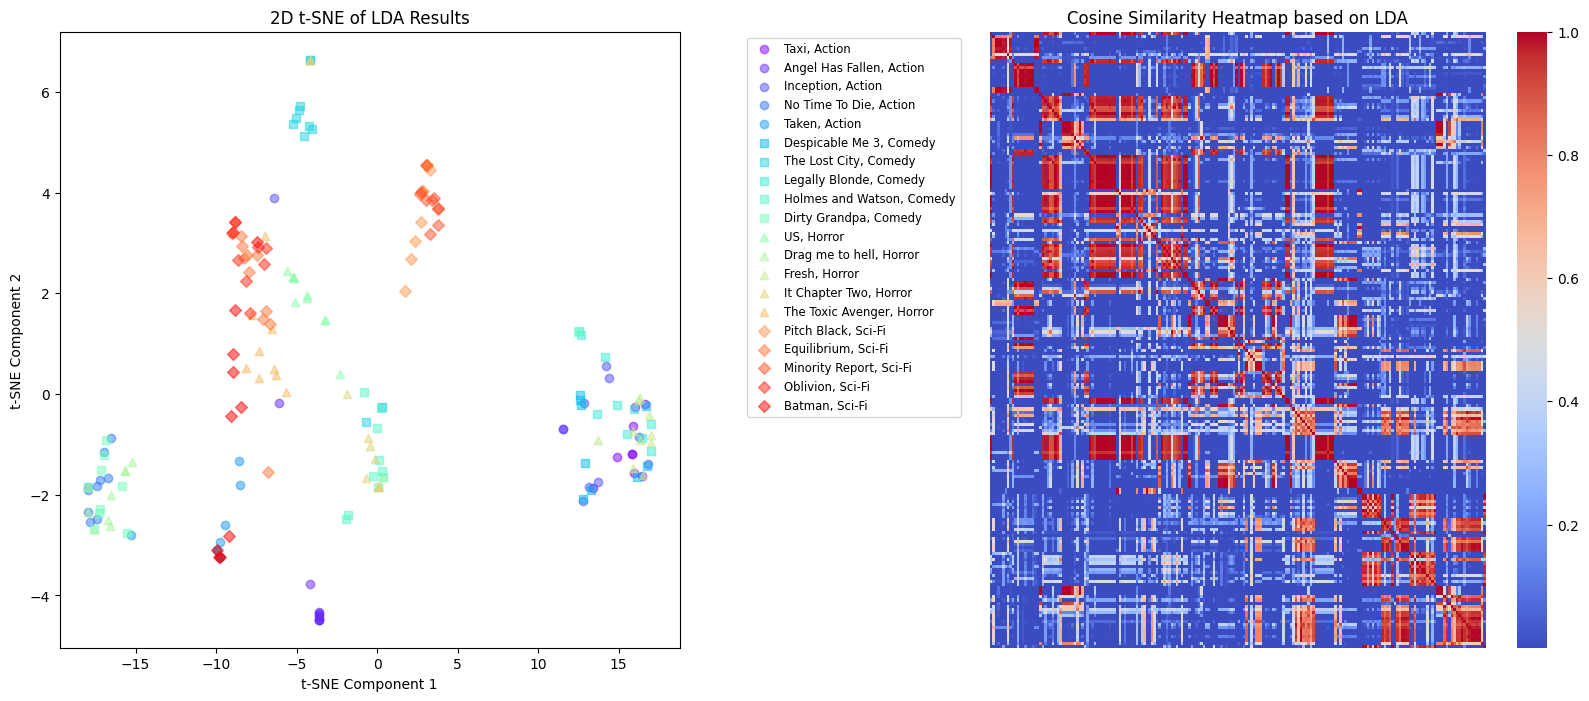

In [11]:
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Assuming wrangled_data, unique_titles, and unique_genres are defined
# Define color_map and marker_map here

# Convert tokenized words into a document-term matrix
def dummy(doc):
    return doc

vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_features=5000)
X_count = vectorizer.fit_transform(wrangled_data['wrangle_three'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42) # using 10 topics for example
X_lda = lda.fit_transform(X_count)

# t-SNE for Dimensionality Reduction on LDA results
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_lda)

# Cosine Similarity based on LDA results
cosine_sim = cosine_similarity(X_lda)

# Creating Subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.5) # adjust space between plots

# 1st subplot: t-SNE Visualization
ax = axs[0]

# Assuming color_map and marker_map are defined based on unique_titles and unique_genres
for title in unique_titles:
    for genre in unique_genres:
        mask = (wrangled_data['Movie Title'] == title) & (wrangled_data['Genre of Movie'] == genre)
        if mask.sum() == 0:
            continue
        
        ax.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            color=color_map[title], marker=marker_map[genre],
            alpha=0.5, label=f"{title}, {genre}"
        )

ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize='small')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('2D t-SNE of LDA Results')

# 2nd subplot: Cosine Similarity Heatmap
ax = axs[1]
sns.heatmap(cosine_sim, ax=ax, cmap='coolwarm', xticklabels=False, yticklabels=False)
ax.set_title('Cosine Similarity Heatmap based on LDA')

plt.show()
